In [ ]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MemotionAnalysisTaskA_2/input_500/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr', 'overall_sentiment'])
df.head()

,image_name,text_corrected,humour,sarcasm,offensive,motivational
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational


In [ ]:
df = df.replace({'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious':3},
            'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 2, 'very_twisted': 3},
            'offensive': {'not_offensive': 0, 'slight': 1, 'very_offensive': 2, 'hateful_offensive': 3},
            'motivational': {'not_motivational': 0, 'motivational': 1}})

In [ ]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

image_name        False
text_corrected    False
humour            False
sarcasm           False
offensive         False
motivational      False
dtype: bool

In [ ]:
width = 100
height = 100
X = []
for i in tqdm(range(cleaned.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = '/content/drive/MyDrive/MemotionAnalysisTaskA_2/original_input/images/'+cleaned['image_name'][i]
        #_path = '../input_100/memotion-dataset-7k/memotion_dataset_7k/images/'+cleaned['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)

X = np.array(X)

 96%|█████████▌| 6676/6987 [38:16<01:54,  2.71it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 6987/6987 [40:01<00:00,  2.91it/s]


In [ ]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg']

In [ ]:
for images in rows_to_drop:
    cleaned.drop(cleaned[cleaned['image_name'] == images].index, inplace=True)

In [ ]:
target = cleaned.iloc[:,2:]
target.head()

,humour,sarcasm,offensive,motivational
0,3,1,0,0
1,0,1,0,1
2,2,0,0,0
3,2,2,2,1
4,3,3,2,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast([.5,2]),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

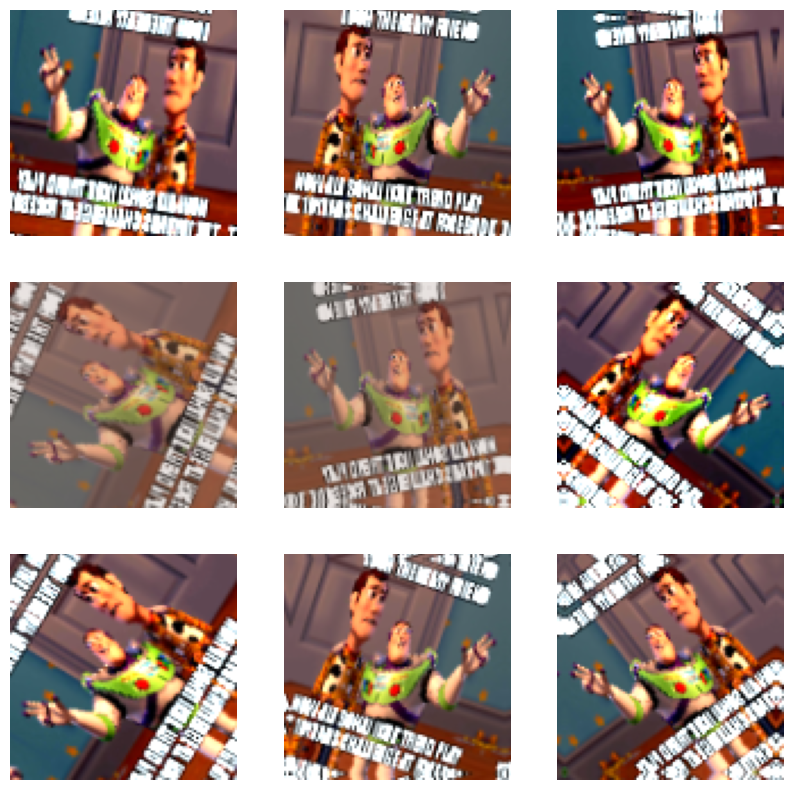

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(X)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model_1.trainable = False
base_model_2.trainable = False

In [ ]:
def image_model():
    image_input = tf.keras.Input(shape=(100, 100, 3), name = 'image_input')
    image_layers = data_augmentation(image_input)
    image_layers = preprocess_input(image_layers)
    layer_bm_1 = base_model_1(image_input, training=False)
    dropout_layer = Dropout(0.2)(layer_bm_1)
    layer_bm_1 = Conv2D(2048, kernel_size=2,padding='valid')(layer_bm_1)
    dropout_layer = Dropout(0.3)(layer_bm_1)
    layer_bm_1 = Dense(512)(dropout_layer)
    dropout_layer = Dropout(0.5)(layer_bm_1)
    layer_bm_2 = base_model_2(image_input, training=False)
    dropout_layer = Dropout(0.4)(layer_bm_2)
    layer_bm_2 = Dense(512)(layer_bm_2)
    dropout_layer = Dropout(0.2)(layer_bm_2)
    layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
    dropout_layer = Dropout(0.3)(layers)
    image_layers = GlobalAveragePooling2D()(layers)
    image_layers = Dropout(0.5, name = 'dropout_layer')(image_layers)
    return image_input, image_layers

In [ ]:
image_input, image_layers = image_model()

In [ ]:
def standardization(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'\w*.com\w*', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

cleaned['text_corrected'] = standardization(cleaned.text_corrected)

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vocab_size = 100000
sequence_length = 100

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = np.asarray(cleaned['text_corrected'])
vectorize_layer.adapt(tf.convert_to_tensor(text_ds))

In [ ]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text_corrected, target, test_size = 0.2)

In [ ]:
embedding_dim=32

def text_model():
    text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
    text_layers = vectorize_layer(text_input)
    text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_layers)
    dropout_layer = Dropout(0.3)(text_layers)

    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True))(text_layers)
    dropout_layer = Dropout(0.4)(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)

    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    dropout_layer = Dropout(0.2)(text_layers)
    text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)
    dropout_layer = Dropout(0.5)(text_layers)

    text_layers = tf.keras.layers.Dense(2048, activation="relu")(text_layers)
    text_layers = tf.keras.layers.Dropout(0.2)(text_layers)
    return text_input, text_layers

text, text_layers = text_model()


In [ ]:
def model(layer_1, layer_2, image_input, text_input):
    concatenate = tf.keras.layers.concatenate([layer_1, layer_2], axis=1)
    semi_final_layer = tf.keras.layers.Dense(2048, activation='relu')(concatenate)

    prediction_layer_1 = tf.keras.layers.Dense(4, activation='softmax', name = 'humuor')
    prediction_layer_2 = tf.keras.layers.Dense(4, activation='softmax', name = 'sarcasm')
    prediction_layer_3 = tf.keras.layers.Dense(4, activation='softmax', name = 'offensive')
    prediction_layer_4 = tf.keras.layers.Dense(2, activation='softmax', name = 'motivational')

    output_1 = prediction_layer_1(semi_final_layer)
    output_2 = prediction_layer_2(semi_final_layer)
    output_3 = prediction_layer_3(semi_final_layer)
    output_4 = prediction_layer_4(semi_final_layer)

    model = tf.keras.Model(inputs = [image_input, text] ,
                           outputs = [output_1, output_2, output_3, output_4])
    return model

In [ ]:
model = model(image_layers, text_layers, image_input, text)

In [ ]:
import os
# Define the checkpoint directory to store the checkpoints
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")


In [ ]:
def decay(epoch):
  if epoch < 5:
    return 1e-3
  elif epoch >= 5 and epoch < 15:
    return 1e-4
  else:
    return 1e-5

In [ ]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [ ]:
base_learning_rate = 0.0001
losses = {
      "humuor": "sparse_categorical_crossentropy",
      "sarcasm": "sparse_categorical_crossentropy",
      "offensive": "sparse_categorical_crossentropy",
      "motivational": "sparse_categorical_crossentropy"
}
lossWeights = {
      "humuor": 1.0,
      "sarcasm": 1.0,
      "offensive": 1.0,
      "motivational": 1.0
}
metrics = {
      "humuor": "sparse_categorical_accuracy",
      "sarcasm": "sparse_categorical_accuracy",
      "offensive": "sparse_categorical_accuracy",
      "motivational": "sparse_categorical_accuracy"
}
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = losses,
              loss_weights= lossWeights,
              metrics=metrics)

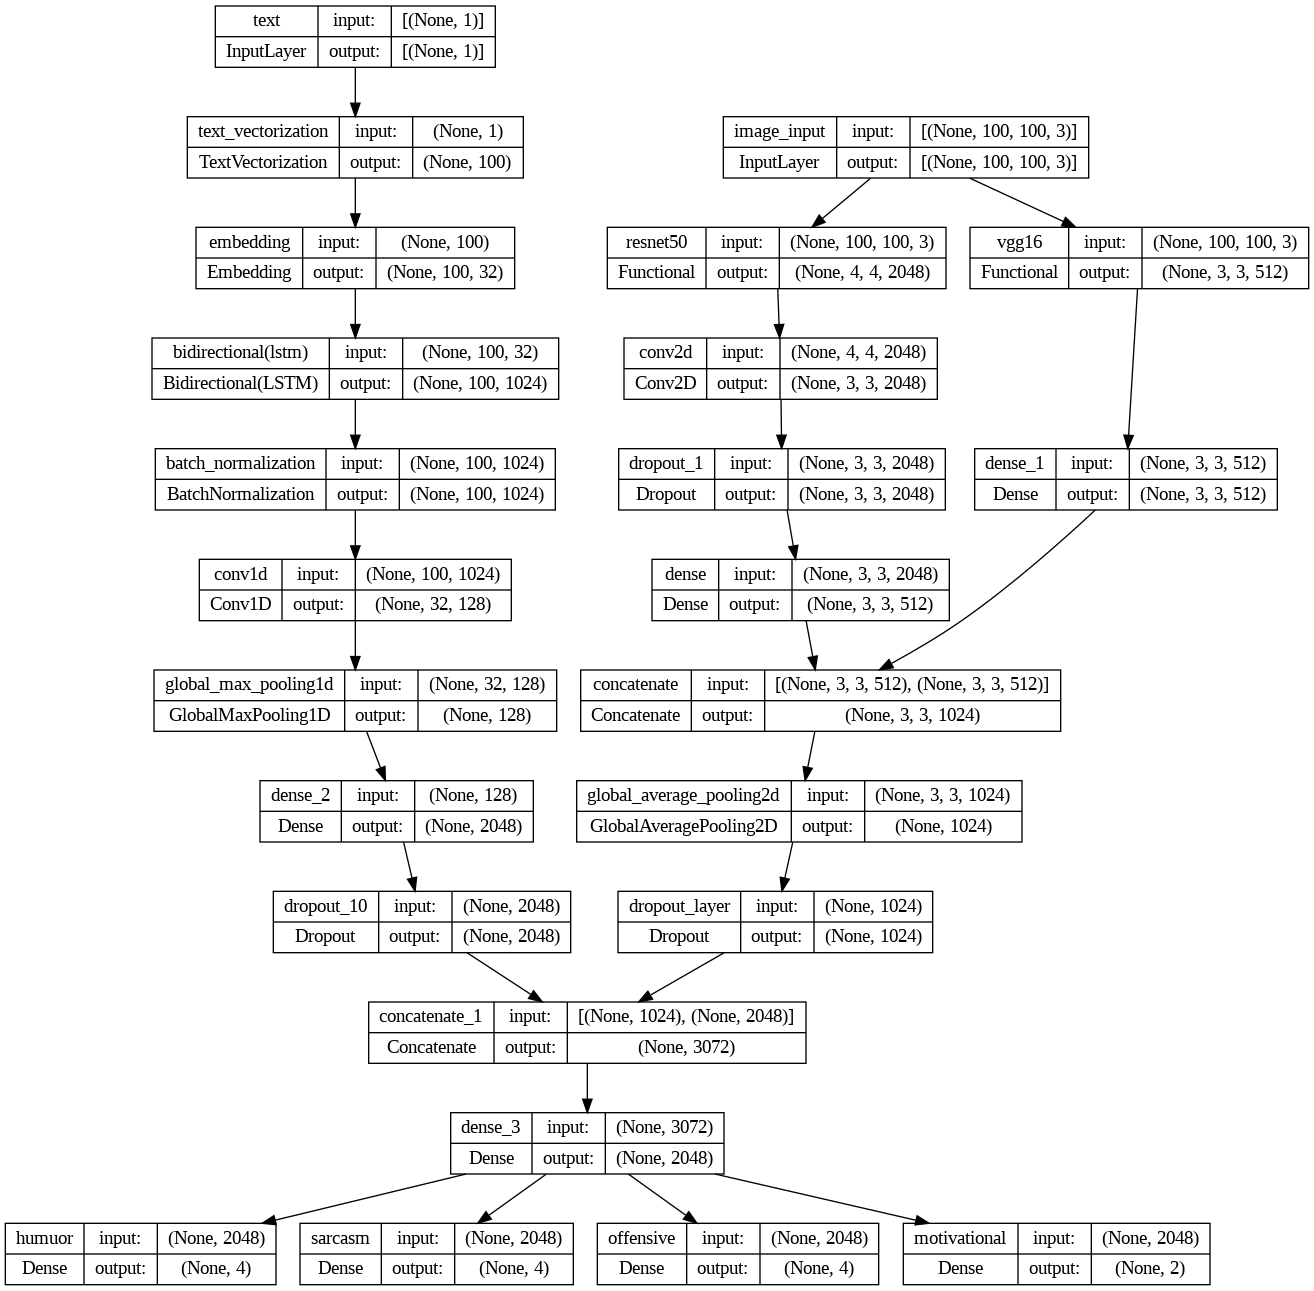

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
history = model.fit(x = {"image_input": X_train, "text": X_text_train},
                    y = {"sarcasm": y_train.sarcasm,
                         "humuor": y_train.humour,
                         "offensive": y_train.offensive,
                         "motivational": y_train.motivational},
                    batch_size=256,
                    epochs=2,
                    validation_data=({"image_input": X_test, "text": X_text_test},
                                     {"sarcasm": y_test.sarcasm,
                                      "humuor": y_test.humour,
                                      "offensive": y_test.offensive,
                                      "motivational": y_test.motivational}),
                    callbacks=callbacks
                   )

Epoch 1/2
22/22 [==============================] - ETA: 0s - loss: 18.2085 - humuor_loss: 5.6980 - sarcasm_loss: 5.9310 - offensive_loss: 4.4299 - motivational_loss: 2.1496 - humuor_sparse_categorical_accuracy: 0.2881 - sarcasm_sparse_categorical_accuracy: 0.3558 - offensive_sparse_categorical_accuracy: 0.3423 - motivational_sparse_categorical_accuracy: 0.5703  
Learning rate for epoch 1 is 0.0010000000474974513
22/22 [==============================] - 1603s 73s/step - loss: 18.2085 - humuor_loss: 5.6980 - sarcasm_loss: 5.9310 - offensive_loss: 4.4299 - motivational_loss: 2.1496 - humuor_sparse_categorical_accuracy: 0.2881 - sarcasm_sparse_categorical_accuracy: 0.3558 - offensive_sparse_categorical_accuracy: 0.3423 - motivational_sparse_categorical_accuracy: 0.5703 - val_loss: 4.9741 - val_humuor_loss: 1.3600 - val_sarcasm_loss: 1.2873 - val_offensive_loss: 1.3265 - val_motivational_loss: 1.0004 - val_humuor_sparse_categorical_accuracy: 0.3422 - val_sarcasm_sparse_categorical_accuracy:

In [ ]:
df_history = pd.DataFrame(history.history)
df_history

,loss,humuor_loss,sarcasm_loss,offensive_loss,motivational_loss,humuor_sparse_categorical_accuracy,sarcasm_sparse_categorical_accuracy,offensive_sparse_categorical_accuracy,motivational_sparse_categorical_accuracy,val_loss,val_humuor_loss,val_sarcasm_loss,val_offensive_loss,val_motivational_loss,val_humuor_sparse_categorical_accuracy,val_sarcasm_sparse_categorical_accuracy,val_offensive_sparse_categorical_accuracy,val_motivational_sparse_categorical_accuracy,lr
0,18.208508,5.697980,5.931003,4.429904,2.149620,0.288093,0.355774,0.342346,0.570278,4.974092,1.359968,1.287250,1.326450,1.000423,0.342162,0.468146,0.381532,0.365068,0.001
1,4.599528,1.369882,1.253035,1.263341,0.713271,0.322471,0.460698,0.357565,0.604834,4.347695,1.299280,1.180085,1.209046,0.659283,0.330709,0.498210,0.377237,0.634932,0.001


In [ ]:
df_history.columns

Index(['loss', 'humuor_loss', 'sarcasm_loss', 'offensive_loss',
       'motivational_loss', 'humuor_sparse_categorical_accuracy',
       'sarcasm_sparse_categorical_accuracy',
       'offensive_sparse_categorical_accuracy',
       'motivational_sparse_categorical_accuracy', 'val_loss',
       'val_humuor_loss', 'val_sarcasm_loss', 'val_offensive_loss',
       'val_motivational_loss', 'val_humuor_sparse_categorical_accuracy',
       'val_sarcasm_sparse_categorical_accuracy',
       'val_offensive_sparse_categorical_accuracy',
       'val_motivational_sparse_categorical_accuracy', 'lr'],
      dtype='object')

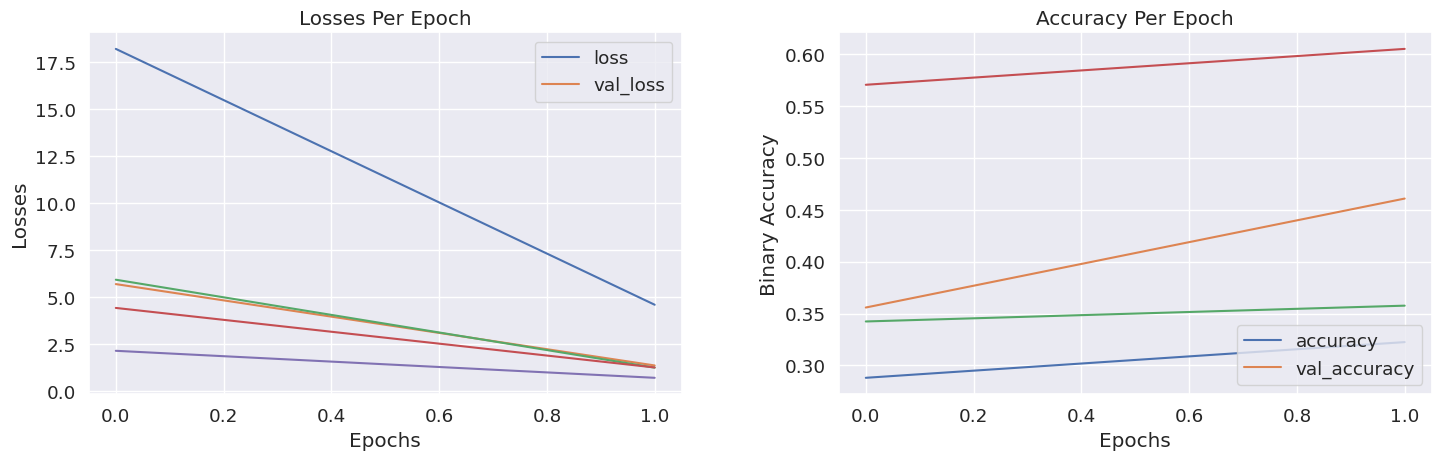

In [ ]:
import seaborn as sns
sns.set(font_scale=1.2)
fig, axes = plt.subplots(1,2, figsize=(16, 6))
fig.tight_layout(pad=5.0)

axes[0].plot(df_history.loss)
axes[0].plot(df_history.humuor_loss)
axes[0].plot(df_history.sarcasm_loss)
axes[0].plot(df_history.offensive_loss)
axes[0].plot(df_history.motivational_loss)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Losses')
axes[0].set_title('Losses Per Epoch')
axes[0].legend(['loss', 'val_loss'], loc='upper right')

axes[1].plot(df_history.humuor_sparse_categorical_accuracy)
axes[1].plot(df_history.sarcasm_sparse_categorical_accuracy)
axes[1].plot(df_history.offensive_sparse_categorical_accuracy)
axes[1].plot(df_history.motivational_sparse_categorical_accuracy)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Binary Accuracy')
axes[1].set_title('Accuracy Per Epoch')
axes[1].legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [ ]:
evaluate = model.evaluate(x = {"image_input": X_test, "text": X_text_test},
                    y = {"sarcasm": y_test.sarcasm,
                         "humuor": y_test.humour,
                         "offensive": y_test.offensive,
                         "motivational": y_test.motivational},
                    batch_size=32,
                   )

44/44 [==============================] - 228s 5s/step - loss: 4.3477 - humuor_loss: 1.2993 - sarcasm_loss: 1.1801 - offensive_loss: 1.2090 - motivational_loss: 0.6593 - humuor_sparse_categorical_accuracy: 0.3307 - sarcasm_sparse_categorical_accuracy: 0.4982 - offensive_sparse_categorical_accuracy: 0.3772 - motivational_sparse_categorical_accuracy: 0.6349


In [ ]:
print("Evaluation Loss: ", evaluate[0])
print("Evaluation Loss on Humuor", evaluate[1])
print("Evaluation Loss on Sarcasm", evaluate[2])
print("Evaluation Loss on Offensive", evaluate[3])
print("Evaluation Loss on Motivational", evaluate[4])
print("Evaluation Accuracy on Humuor", evaluate[5])
print("Evaluation Accuracy on Sarcasm", evaluate[6])
print("Evaluation Accuracy on Offensive", evaluate[7])
print("Evaluation Accuracy on Motivational", evaluate[8])

Evaluation Loss:  4.347694396972656
Evaluation Loss on Humuor 1.299280047416687
Evaluation Loss on Sarcasm 1.180085301399231
Evaluation Loss on Offensive 1.2090461254119873
Evaluation Loss on Motivational 0.6592826843261719
Evaluation Accuracy on Humuor 0.33070865273475647
Evaluation Accuracy on Sarcasm 0.49821045994758606
Evaluation Accuracy on Offensive 0.377236932516098
Evaluation Accuracy on Motivational 0.6349319815635681


In [ ]:
predictions = model.predict(x = {"image_input": X_test, "text": X_text_test})

44/44 [==============================] - 231s 5s/step


In [ ]:
humuor_pred = np.array(predictions[0])
sarcasm_pred = np.array(predictions[1])
offensive_pred = np.array(predictions[2])
motivational_pred = np.array(predictions[3])

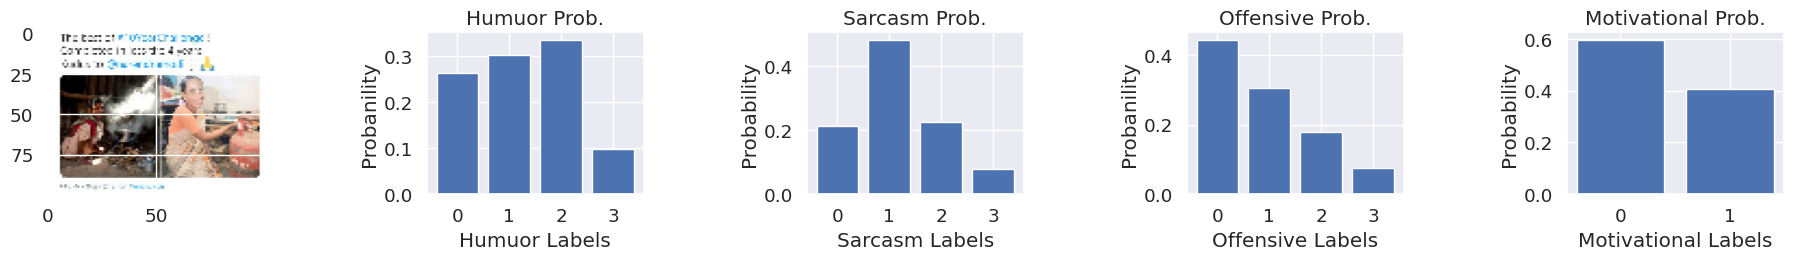

humour          1
sarcasm         1
offensive       0
motivational    0
Name: 6070, dtype: int64


In [ ]:
fig, axes = plt.subplots(1,5, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = [0, 1, 2, 3]

axes[0].imshow(X[1,:,:,:], aspect='auto')

axes[1].bar(x, humuor_pred[1,:])
axes[1].set_xlabel('Humuor Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)

axes[2].bar(x, sarcasm_pred[1,:])
axes[2].set_xlabel('Sarcasm Labels')
axes[2].set_ylabel('Probability')
axes[2].set_title('Sarcasm Prob.')
axes[2].set_xticks(x)

axes[3].bar(x, offensive_pred[1,:])
axes[3].set_xlabel('Offensive Labels')
axes[3].set_ylabel('Probanility')
axes[3].set_title('Offensive Prob.')
axes[3].set_xticks(x)

axes[4].bar([0, 1], motivational_pred[1,:])
axes[4].set_xlabel('Motivational Labels')
axes[4].set_ylabel('Probability')
axes[4].set_title('Motivational Prob.')
axes[4].set_xticks([0, 1])
plt.show()

print(y_test.iloc[1,:])


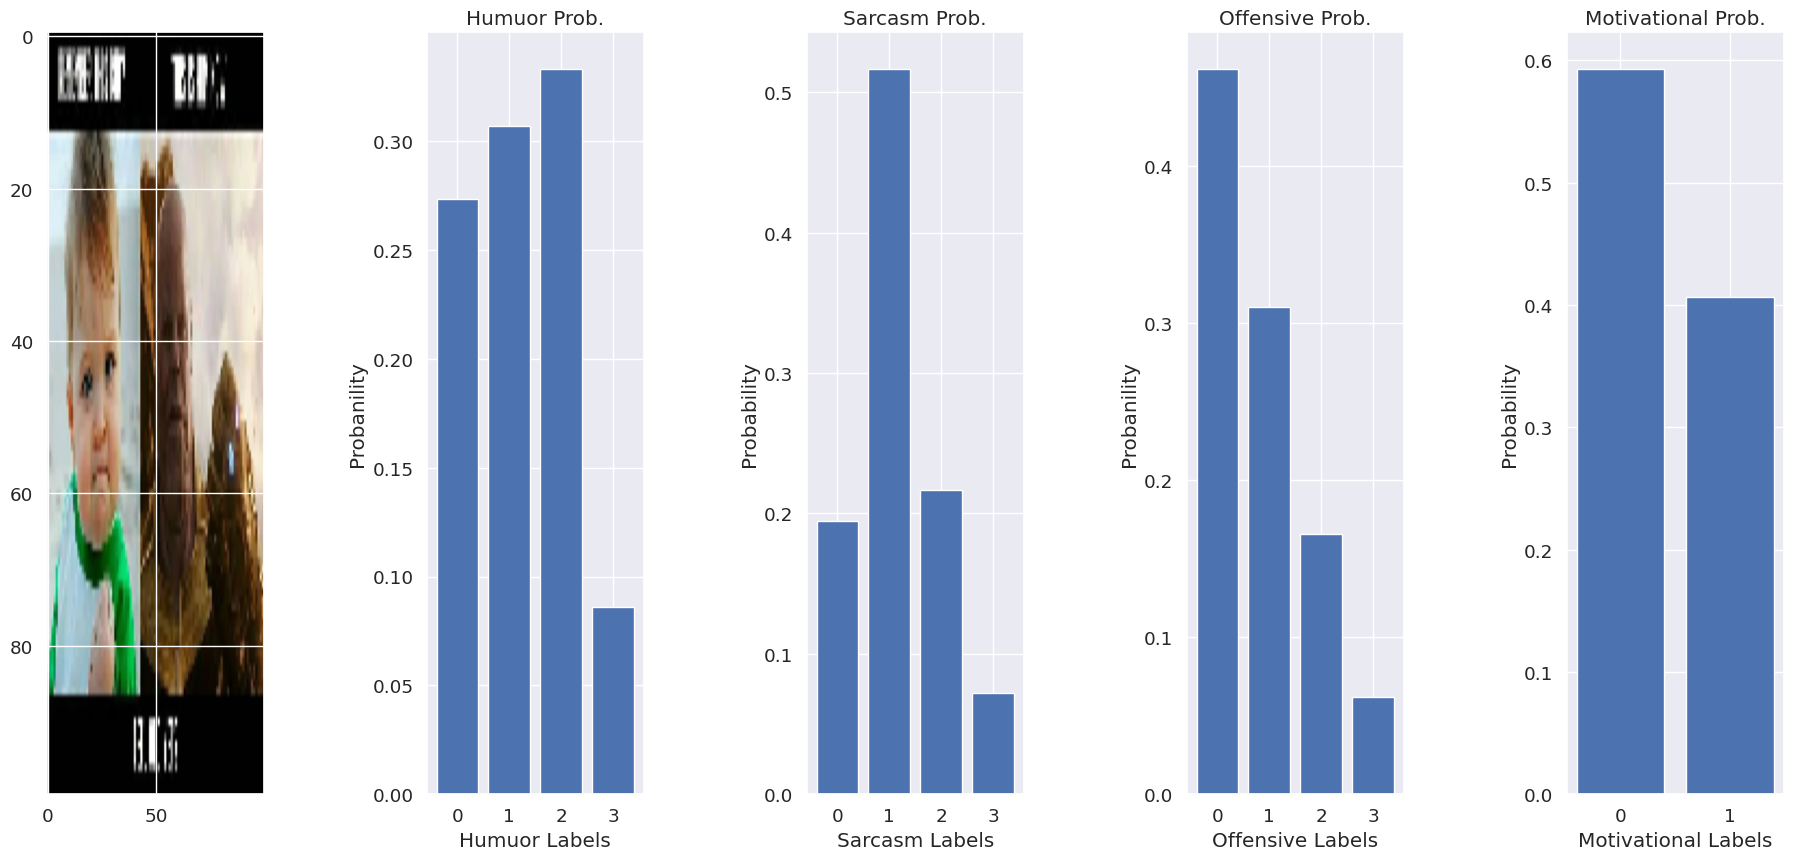

humour          1
sarcasm         1
offensive       1
motivational    0
Name: 1795, dtype: int64


In [ ]:
fig, axes = plt.subplots(1,5, figsize=(20, 10))
fig.tight_layout(pad=5.0)


x = [0, 1, 2, 3]
axes[0].imshow(X[20,:,:,:], aspect='auto')

axes[1].bar(x, humuor_pred[20,:])
axes[1].set_xlabel('Humuor Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)

axes[2].bar(x, sarcasm_pred[20,:])
axes[2].set_xlabel('Sarcasm Labels')
axes[2].set_ylabel('Probability')
axes[2].set_title('Sarcasm Prob.')
axes[2].set_xticks(x)

axes[3].bar(x, offensive_pred[20,:])
axes[3].set_xlabel('Offensive Labels')
axes[3].set_ylabel('Probanility')
axes[3].set_title('Offensive Prob.')
axes[3].set_xticks(x)

axes[4].bar([0, 1], motivational_pred[20,:])
axes[4].set_xlabel('Motivational Labels')
axes[4].set_ylabel('Probability')
axes[4].set_title('Motivational Prob.')
axes[4].set_xticks([0, 1])
plt.show()

print(y_test.iloc[20,:])